In [214]:
import os, sys
import django
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import twitter.models as tm
from django.db.models import Sum, Count
from django.db.models.fields import DateField
from django.db.models.functions import ExtractWeek, ExtractYear
from django.db.models.functions import Cast
from django.contrib.postgres.aggregates import StringAgg, JSONBAgg
import datetime
import textwrap as tw
from matplotlib.collections import LineCollection

import scoping.models as sm
import parliament.models as pm
import igraph
from adjustText import adjust_text
import matplotlib as mpl
from fa2 import ForceAtlas2

mpl.rcParams['font.size'] = 6

dsize = 7.0866142

In [11]:
def tweet_time_graph(s, ax, years = None):
    if s.status_set.exists():
        statuses = s.status_set.all()
        if years:
            start = django.utils.timezone.make_aware(datetime.datetime.now()) - datetime.timedelta(days=years*365)
            statuses = statuses.filter(created_at__gt=start)
        
        byday = statuses.annotate(
            date_only=Cast('created_at', DateField())
        ).values('date_only').annotate(
            n = Count('pk')
        ).order_by('date_only')

        df = pd.DataFrame.from_dict(list(byday))

        df.head()

        df['date_only'] = pd.to_datetime(df['date_only'])

        df.plot('date_only','n', style=".", ax=ax, ms=3)
        ax.set_title(s.string)
        return df

False

wasserstoff: 99990
most retweeted: 868
Sir Schrullich - @PeterHellinger - 2018-03-10 20:23:58+00:00
Wenn man bedenkt, dass man auf einem Felsbrocken lebt der in einem Meer von 1500 Grad heißem Magma schwimmt, das mit 1600 km/h pro Stunde rotiert und mit 30 km/s um einen aktiven Wasserstoff-Fusionsreaktor kreist, gehts eigentlich.


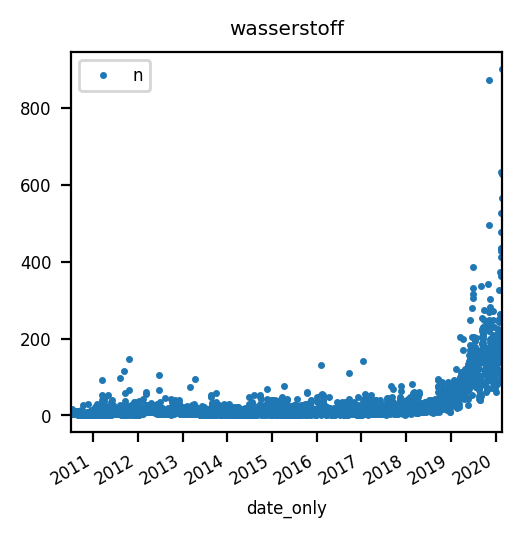

In [12]:
terms =  [
    'wasserstoff',
    #'hydrogen'
]

fig = plt.figure(dpi=200,figsize=(dsize,dsize))

p = sm.Project.objects.get(pk=224)

i=0
fax = None
for t in terms:
    s, created = tm.TwitterSearch.objects.get_or_create(string=t)
    print(created)
    s.project = p
    s.save()
    print(f"\n{s.string}: {s.status_set.count()}")
    if s.status_set.count() > 1:
        ms = s.status_set.order_by('-retweets_count').first()
        print(f"most retweeted: {ms.retweets_count}")
        print(f"{ms.author} - {ms.created_at}")
        print(ms.text)
        
        i+=1
        
        if fax:
            ax = fig.add_subplot(3,3,i,sharex=ax)
        else:
            ax = fig.add_subplot(3,3,i)
            fax = ax
        tweet_time_graph(s, ax)


plt.minorticks_off()
fig.tight_layout()

plt.savefig("plots/tweets_time.png", bbox_inches='tight')

In [27]:
hts = []
s = tm.TwitterSearch.objects.get(string="wasserstoff")
print(s.id, s.string)
for t in s.status_set.filter(entities__hashtags__iregex='\w'):
    for hashtag in t.entities['hashtags']:
        try:
            ht = [x for x in hts if x['text']=="#"+hashtag['text'].lower()][0]
            ht['count']+=1
        except:
            ht = {"text": "#"+hashtag["text"].lower(), "count": 1}
            hts.append(ht) 
  

57 wasserstoff


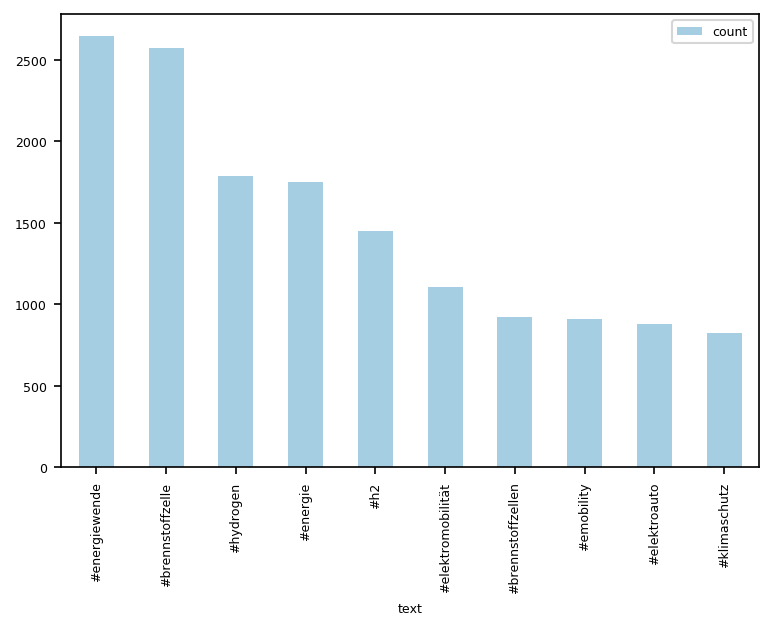

In [30]:
fig, ax = plt.subplots(dpi=150)

ht_df = pd.DataFrame.from_dict(hts).sort_values('count',ascending=False)
ht_df.head(11).tail(10).plot.bar('text','count',colormap='Paired',ax = ax)

plt.show()

In [19]:
last = s.status_set.filter(created_at__isnull=False).order_by('created_at').last().created_at
first = s.status_set.filter(created_at__isnull=False).order_by('created_at').first().created_at
first = django.utils.timezone.make_aware(datetime.datetime(2019,1,1))

now = last
all_hts = []
while now > first:
    hts = []
    last = now
    now = now - datetime.timedelta(days=7)
    for t in s.status_set.filter(entities__hashtags__iregex='\w', created_at__gt=now, created_at__lte=last):
        for hashtag in t.entities['hashtags']:
            try:
                ht = [x for x in hts if x['text']=="#"+hashtag['text'].lower()][0]
                ht['count']+=1
            except:
                ht = {"week":now, "text": "#"+hashtag["text"].lower(), "count": 1}
                hts.append(ht) 
    all_hts += hts

weekly_ht_df = pd.DataFrame.from_dict(all_hts)

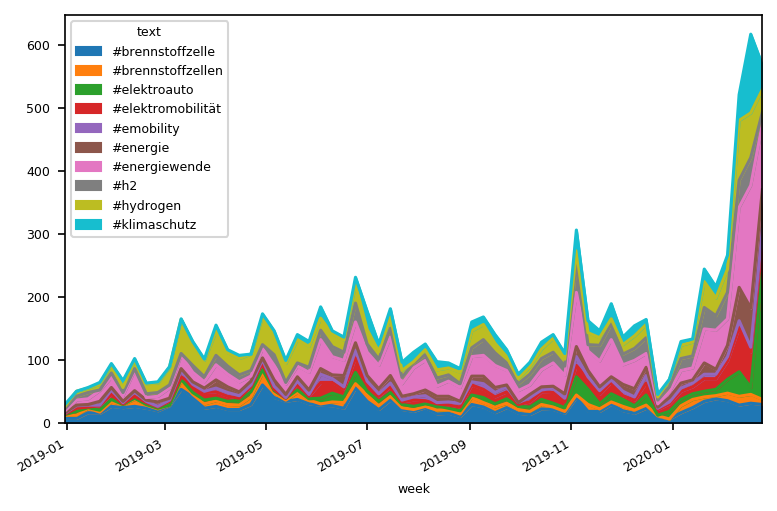

In [37]:
fig, ax = plt.subplots(dpi=150)
ntags = 10
pdf = (weekly_ht_df[weekly_ht_df['text'].isin(ht_df.head(ntags+1).tail(ntags)['text'])]
       .set_index('week')
       .pivot(values="count",columns="text")
       .fillna(0))
pdf.plot.area(ax=ax)

In [ ]:
last = s.status_set.filter(created_at__isnull=False).order_by('created_at').last().created_at
first = s.status_set.filter(created_at__isnull=False).order_by('created_at').first().created_at
first = django.utils.timezone.make_aware(datetime.datetime(2019,1,1))

now = last
all_hts = []
while now > first:
    hts = []
    last = now
    now = now - datetime.timedelta(days=7)
    for t in s.status_set.filter(entities__hashtags__iregex='\w', created_at__gt=now, created_at__lte=last):
        for hashtag in t.entities['hashtags']:
            try:
                ht = [x for x in hts if x['text']=="#"+hashtag['text'].lower()][0]
                ht['count']+=1
            except:
                ht = {"week":now, "text": "#"+hashtag["text"].lower(), "count": 1}
                hts.append(ht) 
    all_hts += hts

weekly_ht_df = pd.DataFrame.from_dict(all_hts)

In [ ]:
pmap = {}
for p in pm.Party.objects.filter(parliament__country__name="Germany"):
    pmap[p.name] = p.colour

In [99]:
party_tweets = pd.DataFrame.from_dict(s.status_set
    .filter(author__person__party__name__isnull=False)
    .values('author__person__party__name')
    .annotate(n=Count('pk'))
).sort_values('n').reset_index(drop=True)

In [101]:
party_tweets

,author__person__party__name,n
0,linke,5
1,afd,7
2,spd,37
3,cducsu,78
4,gruene,79
5,fdp,103


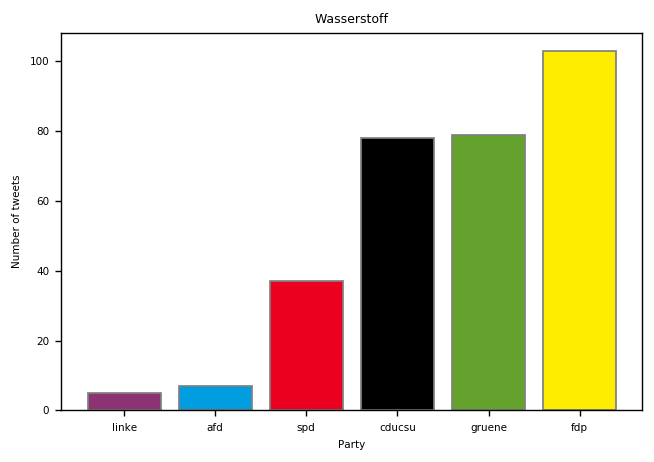

In [390]:
fig, ax = plt.subplots(dpi=125)
ax.bar(
    party_tweets.index,party_tweets.n,
    color=[pmap[x] for x in party_tweets['author__person__party__name']],
    edgecolor="grey",
)
ax.set_xticks(party_tweets.index)
ax.set_xticklabels(party_tweets['author__person__party__name'])
ax.set_ylabel("Number of tweets")
ax.set_xlabel("Party")
ax.set_title("Wasserstoff")
plt.show()

In [47]:
week_party = (s.status_set
    .filter(author__person__party__isnull=False)
    .annotate(year=ExtractYear('created_at'))
    .annotate(week=ExtractWeek('created_at'))
    .values('year', 'week','author__person__party__name','author__person__party__colour')
    .annotate(n=Count('pk'))
)

wp_df = pd.DataFrame.from_dict(list(week_party))
wp_df['date'] = pd.to_datetime(wp_df['year'].map(str) + wp_df['week'].map(str) + '1', format='%Y%W%w')



Text(0, 0.5, 'weekly tweets')

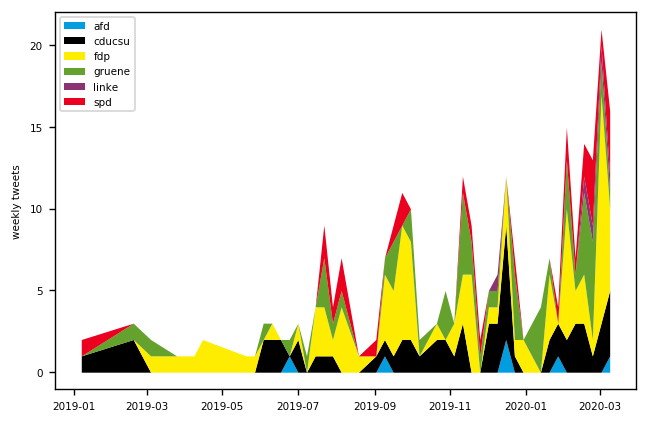

In [395]:
fig, ax = plt.subplots(dpi=125)
wp_wide = (wp_df.loc[wp_df['date']>datetime.datetime(2019,1,1),['author__person__party__name','date','n']]
           .set_index('date')
           .pivot(values='n',columns="author__person__party__name")
           .fillna(0)
          )
y1 = 0
for i,c in enumerate(wp_wide.columns):
    ax.fill_between(
        wp_wide.index,y1,y1+wp_wide[c],
        color=pmap[c],
        lw=0,
        label=c
    )
    y1+=wp_wide[c]
    
ax.legend(loc="upper left")
ax.set_ylabel('weekly tweets')

    

# Retweet network

In [186]:
first = django.utils.timezone.make_aware(datetime.datetime(2020,1,1))
tweet_ids = set(s.status_set.filter(created_at__gt=first).values_list('pk',flat=True))
print(len(tweet_ids))
user_rts = tm.Status.objects.filter(
    pk__in=tweet_ids,
    retweeted_by__isnull=False,
).values('author','retweeted_by').annotate(
    n = Count('pk')
)
print(f"retweeted tweets: {user_rts.count()}")
user_rts.order_by('-n')

from collections import ChainMap
tweeters = set(user_rts.values_list('author',flat=True))
retweeters = set(user_rts.values_list('retweeted_by',flat=True))
print(f"{len(tweeters)} tweeters")
print(f"{len(retweeters)} retweeters")
user_ids = tweeters | retweeters
id_map = [{uid: i} for i,uid in enumerate(user_ids)]
id_map = dict(ChainMap(*id_map))


17979
retweeted tweets: 4110
725 tweeters
2693 retweeters


In [371]:
g = igraph.Graph()
g.add_vertices(len(user_ids))

# get tweets and user info and aggregate hashtags by user
u_tweets = user_rts.values('author').annotate(
    hts = JSONBAgg("entities__hashtags__text")
)
users = tm.User.objects.filter(pk__in=user_ids).values('pk','name','person__party__colour')
user_dict = {u['pk']: {"name":u["name"],"colour":u["person__party__colour"], "hashtags":None} for u in users}
for u in u_tweets:
    user_dict[u['author']]['hashtags'] = [ht["text"] for ht in u['hts'][0]['hashtags']]


tuids = list(tm.Status.objects.filter(
    pk__in=tweet_ids,
    retweeted_by__isnull=False
).values_list('author__id',flat=True))
colours = [None] * len(user_ids)
tweet_n = [None] * len(user_ids)
names = [None] * len(user_ids)
hts = [None] * len(user_ids)

for uid, i in id_map.items():
    u = user_dict[uid]
    names[i] = u["name"]
    tweet_n[i] = len([t for t in tuids if t==uid])
    hts[i] = u["hashtags"]
    if u["colour"]:
        colours[i] = u["colour"]
    else:
        colours[i] = "#d3d3d3"
        
g.vs["twitter-name"] = names
g.vs["color"] = colours
g.vs["tweets"] = tweet_n
g.vs["hashtags"] = hts


weights = []
edges = []
for ur in user_rts:
    if ur['author'] in id_map and ur['retweeted_by'] in id_map:
        edges.append((id_map[ur['author']],id_map[ur['retweeted_by']]))
        weights.append(ur['n'])

g.add_edges(edges)
g.es['weight'] = weights

print(g.summary())



IGRAPH U-W- 3183 4110 -- 
+ attr: color (v), hashtags (v), tweets (v), twitter-name (v), weight (e)


In [372]:
sg = g.simplify(combine_edges={ "weight": "sum" }).clusters().giant()
print(sg.summary())

IGRAPH U-W- 2490 3584 -- 
+ attr: color (v), hashtags (v), tweets (v), twitter-name (v), weight (e)


In [373]:
clusters = sg.community_fastgreedy(weights="weight")
#clusters = sg.community_infomap() # very small clusters
cl = clusters.as_clustering()
#cl = sg.community_label_propagation() # many small clusters
#cl = sg.community_spinglass()


In [374]:
print(len(cl), "clusters")
for c in cl:
    print(len(c))

44 clusters
102
45
155
30
473
93
180
107
50
80
178
117
113
76
79
78
33
55
11
67
40
87
67
17
17
7
3
9
10
6
6
8
20
3
19
9
4
3
3
12
5
5
5
3


In [375]:
def chaikins_corner_cutting(coords, refinements=5):

    for _ in range(refinements):
        L = coords.repeat(2, axis=0)
        R = np.empty_like(L)
        R[0] = L[0]
        R[2::2] = L[1:-1:2]
        R[1:-1:2] = L[2::2]
        R[-1] = L[-1]
        coords = L * 0.75 + R * 0.25

    return coords

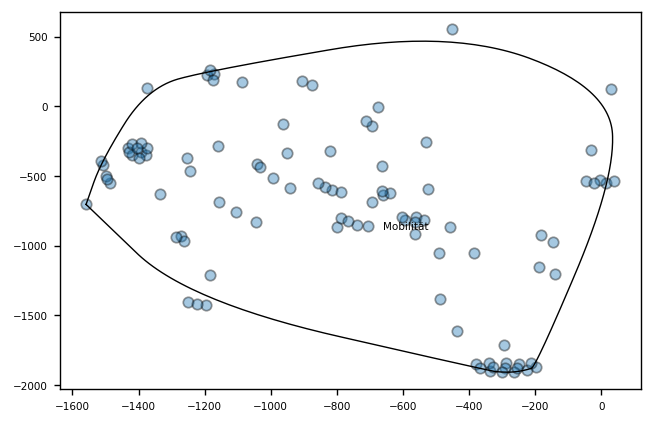

In [376]:
fig, ax = plt.subplots(dpi=125)
from collections import Counter
from scipy.spatial import ConvexHull
c = cl[0]
hts = np.hstack(g.vs[c]['hashtags'])
count = Counter([h for h in hts if h is not None])
count.most_common()[0]
x = [x[0] for i,x in enumerate(layout) if i in c]
y = [x[1] for i,x in enumerate(layout) if i in c] 
cx = np.dot(x, y) / np.sum(y)
scatter = ax.scatter(x,y,edgecolor="black",alpha=0.4)
hts = np.hstack(g.vs[c]['hashtags'])
count = Counter([h for h in hts if h is not None and h!="Wasserstoff"])
if count:
    mc = count.most_common()[0]
    lpoints = np.array(list((zip(x,y))))
    hull = ConvexHull(lpoints)
    cx = np.mean(hull.points[hull.vertices,0])
    cy = np.mean(hull.points[hull.vertices,1])
    c = [cx,cy]
    ax.text(cx,cy,mc[0])
    
    x = lpoints[hull.vertices,0]
    x = np.append(x,[x[:1]])
    y = lpoints[hull.vertices,1]
    y = np.append(y,[y[:1]])
    coords = np.array(list(zip(x,y)))
    coords = chaikins_corner_cutting(coords)


    x2 = coords[:,0]
    y2 = coords[:,1]

    #x2 = interpolate.BSpline(t, x, nt)
    #y2 = interpolate.BSpline(t, y, nt)
    plt.plot(x2, y2,'k-',linewidth=0.8)


In [296]:
hull


In [385]:
vs[0]

igraph.Vertex(<igraph.Graph object at 0x7fb6790c75e8>, 978, {'twitter-name': 'Max Fuhr', 'color': '#d3d3d3', 'tweets': 0, 'hashtags': None})

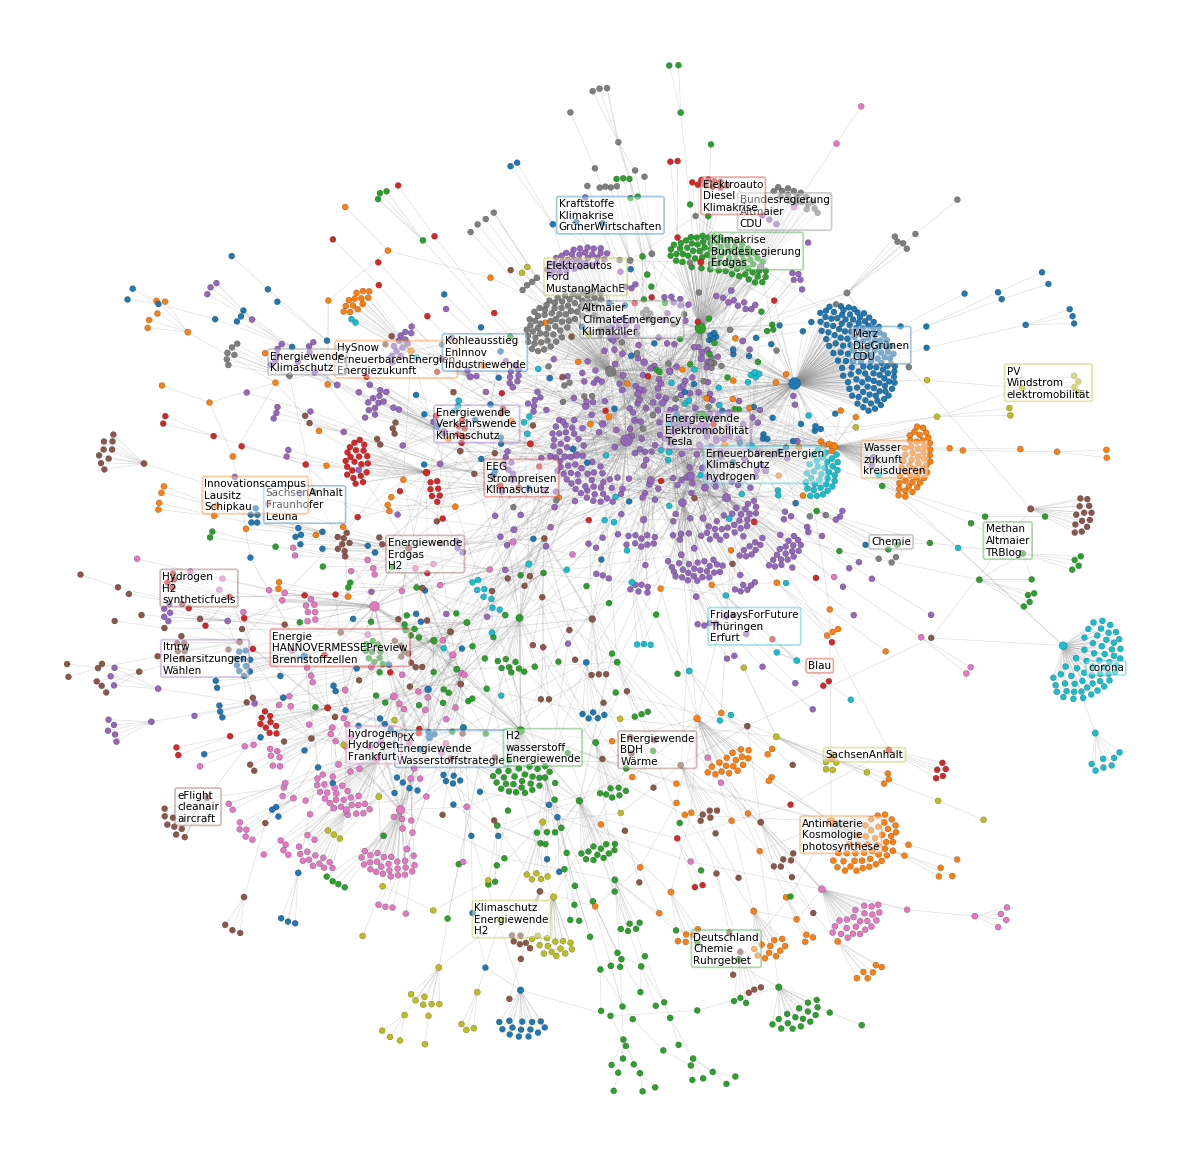

In [386]:
fig, ax = plt.subplots(figsize=(12,12),dpi=125)

alpha = 0.25  
es  = [(layout[e.source],layout[e.target]) for e in sg.es]
lw = [0.05+(np.log(e['weight']+1)*0.5) for e in sg.es]
lc = LineCollection(es,colors="grey",alpha=alpha,linewidths=lw,zorder=-1)
ax.add_collection(lc)
    
for c in cl:
    x = [x[0] for i,x in enumerate(layout) if i in c]
    y = [x[1] for i,x in enumerate(layout) if i in c] 
    vs = sg.vs[c]
    col = [v["color"] for v in vs if v["color"] is not None]
    s = [12 + v["tweets"]*0.15 for v in vs]
    lw = [0.1 for v in g.vs ]
    scatter = ax.scatter(x,y,s=s,edgecolor="black",linewidths=lw)
    #scatter = ax.scatter(x,y,c=col,s=s,edgecolor="black",linewidths=lw)
    hts = np.hstack(vs['hashtags'])
    count = Counter([h for h in hts if h is not None and h!="Wasserstoff"])
    if count:
        
        mct = count.most_common()[0][0]
        mct = "\n".join([t[0] for t in count.most_common()[:3]])
        lpoints = np.array(list((zip(x,y))))
        hull = ConvexHull(lpoints)
        cx = np.mean(hull.points[hull.vertices,0])
        cy = np.mean(hull.points[hull.vertices,1])
        cx = np.mean(x)
        cy = np.mean(y)
        c = [cx,cy]
        ax.text(cx,cy,mct,zorder=5, bbox={
            'facecolor':"white", 'alpha':0.4, 'pad':0.2, 'boxstyle': 'round',
            'edgecolor': scatter._facecolors[0]
        })
        
ax.grid(False)
ax.axis('off')

plt.show()

In [322]:
scatter._facecolors

array([[0.83921569, 0.15294118, 0.15686275, 1.        ]])

In [197]:
g = g.clusters().giant()
ig_layout = g.layout("fr")

In [205]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

fa_layout = forceatlas2.forceatlas2_igraph_layout(g, pos=None, iterations=2000)

100%|██████████| 2000/2000 [01:18<00:00, 25.56it/s]

BarnesHut Approximation  took  36.13  seconds
Repulsion forces  took  37.49  seconds
Gravitational forces  took  0.26  seconds
Attraction forces  took  0.20  seconds
AdjustSpeedAndApplyForces step  took  1.52  seconds


In [199]:
labels = []
for i, d in enumerate(g.degree()):
    if d > 5:
        labels.append({
            "id": i,
            "name": g.vs["twitter-name"][i],
            "d": d 
        })
        
labels = sorted(labels, key=lambda k: k['d'], reverse=True)
labels[:5]

[{'d': 233, 'id': 1888, 'name': 'Volker Quaschning'},
 {'d': 173, 'id': 818, 'name': 'Jürgen Döschner'},
 {'d': 169, 'id': 2393, 'name': 'Claudia Kemfert'},
 {'d': 160, 'id': 1766, 'name': 'Constantin Zerger'},
 {'d': 87, 'id': 1134, 'name': 'Karl Lauterbach'}]

In [200]:
def draw_network(ax, g, layout, labels, interactive=False):
    #label_ids = [l['id'] for l in labels]
    x = [x[0] for x in layout]
    y = [x[1] for x in layout]
    c = [v["color"] for v in g.vs if v["color"] is not None]
    
    s = [12 + v["tweets"]*0.15 for v in g.vs]
    lw = [0.1 for v in g.vs ]

    scatter = ax.scatter(x,y,c=c,s=s,edgecolor="black",linewidths=lw)
     
    alpha = 0.25  
    es  = [(layout[e.source],layout[e.target]) for e in g.es]
    lw = [0.05+(np.log(e['weight']+1)*0.5) for e in g.es]
    lc = LineCollection(es,colors="grey",alpha=alpha,linewidths=lw,zorder=-1)
    ax.add_collection(lc)
    
    texts = []
    for l in labels:
        xy = layout[l["id"]]
        texts.append(ax.text(xy[0],xy[1],l["name"],fontsize=8))

    adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    for text in texts:
        text.set_alpha(0.7)
        
    ax.grid(False)
    ax.axis('off')
    
    if interactive:
        tooltip =  mpld3.plugins.PointLabelTooltip(
            scatter, 
            labels=[x for x in g.vs["twitter-name"] if x is not None]
        )
        return tooltip



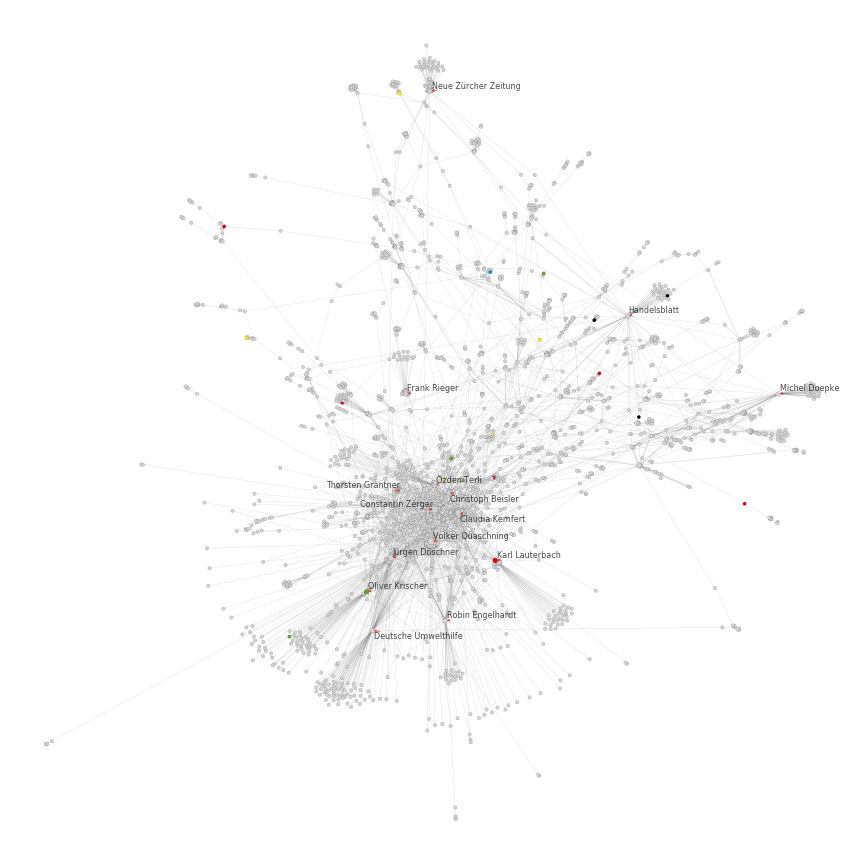

In [206]:
fig, ax = plt.subplots(figsize=(12,12))

draw_network(ax, g, fa_layout, labels[:15])

fig.tight_layout()

plt.savefig(f'plots/rt_network_{s.string}.png', bbox_inches="tight")

plt.show()

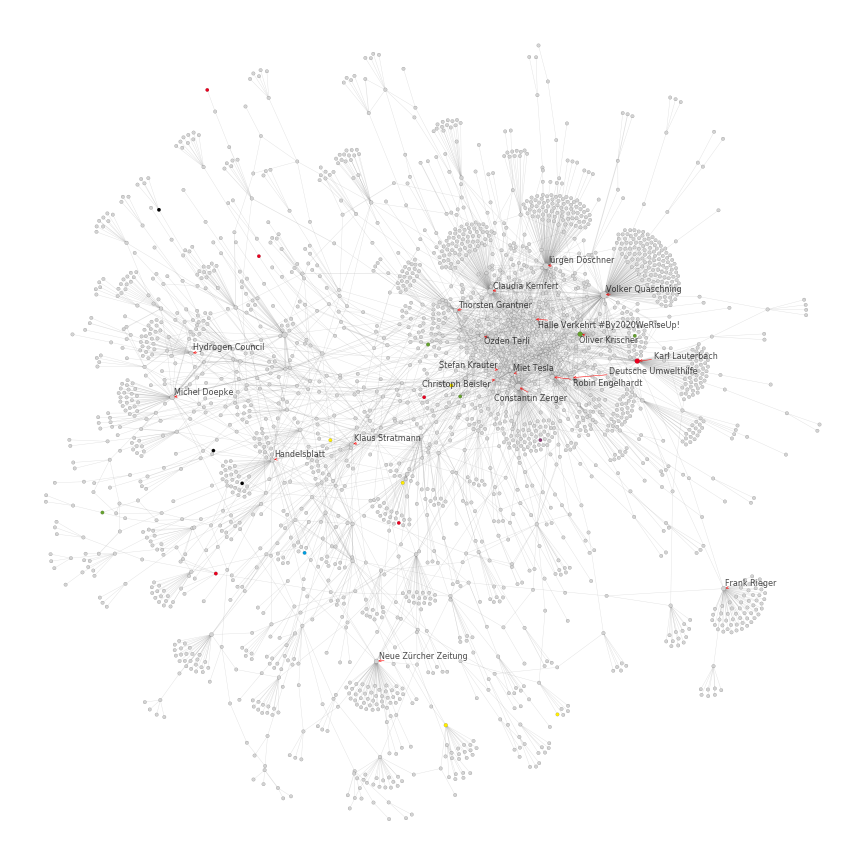

In [387]:
fig, ax = plt.subplots(figsize=(12,12))

draw_network(ax, sg, ig_layout, labels[:20])

fig.tight_layout()

plt.savefig(f'plots/rt_network_wasserstoff.png', bbox_inches="tight")

plt.show()